# Clasificación Multiclase

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

En este ejemplo vamos a construir una red para clasificar las noticias de Reuters según una clasificación que contiene 46 tópicos disjuntos. Por ello, estamos ante un problema de **Clasificación Multi-Clase** (concretamente, de etiqueta única, porque cada ejemplo solo puede ser asignado a una de las clases).

El problema analizado es muy similar al que ya hemos visto de opiniones de IMDB, por lo que profundizaremos únicamente en aquellas fases que lo diferencian.

## El dataset de Reuters

Vamos a trabajar sobre el *dataset de Reuters*, un conjunto de noticias cortas clasificadas por tópicos, que publicó la empresa de noticias Reuters en 1986 y que se ha usado ampliamente como ejemplo en problemas de clasificación. Este dataset hace uso de 46 tópicos distintos, algunos con más representación que otros, pero en el que, al menos, cada tópico etiqueta 10 noticias del conjunto de entrenamiento.

Este datset también viene empaquetado en Keras y su carga es directa y similar a las que hemos realizado en los ejemplos anteriores:

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Tenemos 8,982 ejemplos de entrenamiento y 2,246 ejemplos de test:


In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

Al igual que en el caso de IMDB, los ejemplos son listas de enteros que representan índices de palabras de un diccionario:


In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Que podemos decodificar de forma completamente análoga a como lo hicimos entonces:


In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

La etiqueta asociada a una noticia es un entero entre 0 y 45, que representa el índice de un tópico.


In [8]:
train_labels[10]

3

## Preparando los datos

Usamos exactamente las mismas funciones para vectorizar los datos y prepararlos como entrada a la red neuronal:

In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


La diferencia principal ahora es que antes estas etiquetas eran binarias y ahora son números enteros. Podríamos tratarlas como enteros (tensores escalares) o bien hacer una codificación _one-hot_ tal y como hicimos antes, que será la opción que tomemos siguiendo un patrón similar al realizado para las vectorizaciones anteriores (aunque, en este caso, como cada noticia solo puede tener asociado un tópico, los vectores tendrán solo un 1 y todo lo demás 0s):


In [10]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Esta tarea es tan común que hHay una función de Keras que realiza ya esta labor, y que vimos en el primer ejemplo que estudiamos de MNIST. Su resultado es exactamente el mismo que el de la función anterior:


In [11]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Construyendo la red

Como ahora la salida debe tener 46 unidades, no tiene sentido comprimir las capas anteriores a 16 unidades, ya que estaríamos creando un cuello de botella en esa parte de la red, así que trabajaremos con 2 capas densas de 64 unidades, y una capa densa de salida con 46 unidades (una por cada posible tópico) pero de activación `softmax`:

In [12]:
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model

red = models.Sequential()
red.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
red.add(layers.Dense(64, activation='relu'))
red.add(layers.Dense(46, activation='softmax'))

plot_model(red, to_file='ReutersModel_plot.png', show_shapes=True, show_layer_names=True)

![](./imgs/ReutersModel_plot.png)

Destaquemos las diferencias que podemos encontrar respedto al caso anterior:

* La red acaba con una capa densa de 46 unidades, de forma que la salida será un vector de tamaño 46, uno por cada posible clase de salida.

* La última capa usa activación `softmax`, lo que significa que la salida se podrá interpretar como una *distribución de probabilidad* sobre las diferentes clases de salida (un vector positivo de tamaño 46 y que suma 1).

Siguiendo un razonamiento similar al caso del IMDB, la función de pérdida adecuada en este caso es `categorical_crossentropy` (similar, pero para el caso no binario):

In [13]:
red.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validando el modelo

Al igual que antes, vamos a separar 1,000 muestras del conjunto de entrenamiento para formar un conjunto de validación que nos servirá para evaluar cómo funciona el modelo a medida que va aprendiendo (y controlar, por ejemplo, el *overfitting*):

In [19]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Ahora entrenemos el modelo con 20 epochs, usando el conjunto de validación para tener información adicional de cómo evoluciona:


In [20]:
entrenamiento = red.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 0s 55us/step - loss: 0.2072 - acc: 0.9480 - val_loss: 0.5470 - val_acc: 0.8970
Epoch 2/20
7982/7982 [==============================] - 0s 54us/step - loss: 0.1808 - acc: 0.9521 - val_loss: 0.5572 - val_acc: 0.8850
Epoch 3/20
7982/7982 [==============================] - 0s 56us/step - loss: 0.1630 - acc: 0.9540 - val_loss: 0.5878 - val_acc: 0.8850
Epoch 4/20
7982/7982 [==============================] - 0s 57us/step - loss: 0.1487 - acc: 0.9551 - val_loss: 0.5794 - val_acc: 0.8830
Epoch 5/20
7982/7982 [==============================] - 0s 60us/step - loss: 0.1410 - acc: 0.9555 - val_loss: 0.6026 - val_acc: 0.8850
Epoch 6/20
7982/7982 [==============================] - 0s 62us/step - loss: 0.1288 - acc: 0.9585 - val_loss: 0.6310 - val_acc: 0.8730
Epoch 7/20
7982/7982 [==============================] - 0s 61us/step - loss: 0.1222 - acc: 0.9564 - val_loss: 0.6554 - val_acc: 0.8750
Epoch 8

Podemos mostrar las curvas de pérdida y accuracy en los datos de entrenamiento y validación::


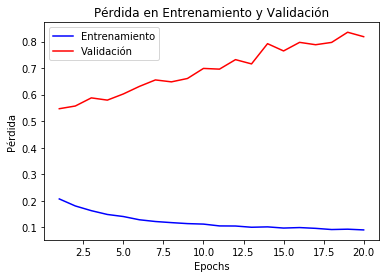

In [21]:
import matplotlib.pyplot as plt

ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

epochs = range(1, len(ent_loss) + 1)

plt.plot(epochs, ent_loss, 'b', label='Entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

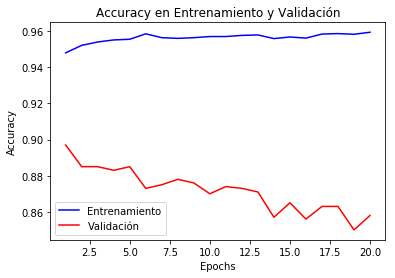

In [23]:
plt.clf()   # clear figure

ent_acc = entrenamiento.history['acc']
val_acc = entrenamiento.history['val_acc']

plt.plot(epochs, ent_acc, 'b', label='Entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Que nos muestran que el modelo comienza a sobreajustar a partir de la 9ª epoch, por lo que entrenaremos un modelo limpio solo durante 9 epochs, y mediremos su rendimiento con los datos de test:


In [24]:
red2 = models.Sequential()
red2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
red2.add(layers.Dense(64, activation='relu'))
red2.add(layers.Dense(46, activation='softmax'))

red2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
red2.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = red2.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 78us/step - loss: 2.6881 - acc: 0.4981 - val_loss: 1.8012 - val_acc: 0.6340
Epoch 2/8
7982/7982 [==============================] - 0s 53us/step - loss: 1.4756 - acc: 0.7015 - val_loss: 1.3728 - val_acc: 0.6870
Epoch 3/8
7982/7982 [==============================] - 0s 56us/step - loss: 1.0966 - acc: 0.7669 - val_loss: 1.1740 - val_acc: 0.7520
Epoch 4/8
7982/7982 [==============================] - 0s 55us/step - loss: 0.8697 - acc: 0.8127 - val_loss: 1.0609 - val_acc: 0.7830
Epoch 5/8
7982/7982 [==============================] - 0s 57us/step - loss: 0.7016 - acc: 0.8513 - val_loss: 1.0108 - val_acc: 0.7860
Epoch 6/8
7982/7982 [==============================] - 0s 58us/step - loss: 0.5659 - acc: 0.8809 - val_loss: 0.9495 - val_acc: 0.8080
Epoch 7/8
7982/7982 [==============================] - 0s 53us/step - loss: 0.4583 - acc: 0.9054 - val_loss: 0.9296 - val_acc: 0.8030
Epoch 8/8
2246

In [25]:
results

[1.0018587503068064, 0.7827248441674087]


El modelo obtenido consigue una accuracy de ~78%. Si la clasificación fuera binaria y estuviera balanceada, un calsificador aleatorio alcanzaría un 50%, pero al ser multi-clase en este caso uno aleatorio esperaría no más del 19%, por lo no lo hace nada mal:


In [26]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19323241317898487

## Predicciones en nuevos datos

Usando el método `predict` podemos ver cómo nuestro modelo funciona sobre datos no vistos. Por ejemplo, si trabajamos sobre los datos de test:

In [27]:
predictions = red2.predict(x_test)

Podemos comprobar que cada entrada de `predictions` es un vector de longitud 46:


In [28]:
predictions[0].shape

(46,)

Cuyos coeficientes suman 1:


In [29]:
np.sum(predictions[0])

0.9999998

Y donde el mayor valor indica la predicción del modelo (la mayor probabilidad:


In [30]:
np.argmax(predictions[0])

3

## Salidas Categóricas Discretas

Si hubiéramos decidido manejar las etiquetas directamente como valores enteros, entonces hubiera sido conveniente cambiar de función de pérdida de `categorical_crossentropy` a `sparse_categorical_crossentropy`, que está preparada para medir errores cuando las salidas son categóricas pero no continuas (como en el caso de distribuciones de probabilidad):

In [31]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [32]:
red2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

En realidad, es la misma función que antes, pero con transformaciones internas para manejar valores enteros.


## Tamaño de las capas intermedias

Podemos hacer el experimento de ver qué pasaría si trabajáramos con capas intermedias que producen cuellos de botella a la información que se transmite a lo largo de la red. Por ejemplo, si la segunda capa la cambiamos a 4 unidades:

In [33]:
red3 = models.Sequential()
red3.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
red3.add(layers.Dense(4, activation='relu'))
red3.add(layers.Dense(46, activation='softmax'))

red3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
red3.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 66us/step - loss: 2.9259 - acc: 0.3579 - val_loss: 2.1839 - val_acc: 0.4920
Epoch 2/20
7982/7982 [==============================] - 0s 43us/step - loss: 1.7924 - acc: 0.5818 - val_loss: 1.5956 - val_acc: 0.6060
Epoch 3/20
7982/7982 [==============================] - 0s 44us/step - loss: 1.4206 - acc: 0.6287 - val_loss: 1.4530 - val_acc: 0.6330
Epoch 4/20
7982/7982 [==============================] - 0s 48us/step - loss: 1.2409 - acc: 0.6751 - val_loss: 1.3694 - val_acc: 0.6510
Epoch 5/20
7982/7982 [==============================] - 0s 47us/step - loss: 1.1029 - acc: 0.6939 - val_loss: 1.3084 - val_acc: 0.6660
Epoch 6/20
7982/7982 [==============================] - 0s 49us/step - loss: 0.9814 - acc: 0.7315 - val_loss: 1.2697 - val_acc: 0.7010
Epoch 7/20
7982/7982 [==============================] - 0s 49us/step - loss: 0.8748 - acc: 0.7709 - val_loss: 1.2550 - val_acc: 0.7150
Epoch 8


Podemos observar que el rendimiento del modelo cae al ~66% de accuracy, un 12% de caida respecto a la aproximación anterior, debido al hecho de que ahora la red intenta comprimir toda la información de las 64 neuronas anteriores en 4 neuronas para volver a descomprimirlo en 46 neuronas de salida, y aunque es capaz de mantener mucha información en esas pocas neuronas, pierde mucha estructura de la información original en ese proceso.


### Trabajo Propuesto

* Intenta usar otro tamaño en las capas, ampliando o reduciendo: 32, 128,...
* Intenta usar más o menos cantidad de capas ocultas.

## Conclusiones

Algunas conclusiones que podemos ir apuntando de este ejemplo:

* Si quieres clasificar entre $N$ clases, tu red debe acabar en una capa densa de tamaño $N$.
* Si la clasificación es disjunta, la última capa debe usar activación `softmax`, de esa forma obtendrás una distribución de probabilidad sobre las N clases de salida.
* Casi con toda seguridad tendrás que usar *Categorical crossentropy* como función de pérdida.
* Hay dos formas de manejar las etiquetas en un problema de clasificación multi-clase:
    * Por _Codificación Categórica_ ("one-hot encoding") y usando `categorical_crossentropy` como función de pérdida.
    * Codificando las etiquetas como enteros, y usando `sparse_categorical_crossentropy` como función de pérdida.
* Si el número de categorías es muy alto, evita los cuellos de botella con capas intermedias demasiado pequeñas.